## Import Libs

In [1]:
import json
import pandas as pd
import boto3
from boto3.dynamodb.conditions import Key
from time import gmtime, strftime
from creds import *
import random
from datetime import date

In [ ]:
#client.delete_table(TableName = "clin_test2")

## Wrap Dynamo Querying function

In [43]:
def query_dynamo(domain,studyid,**kwargs):
    list_cols = kwargs.get('list_cols', None)
    global df2
    if studyid == "all":
        response = table.query(
        KeyConditionExpression=Key('domain').eq(str(domain))
        )

        item = response['Items']
        df2 = pd.json_normalize(item,sep='')
        df2 = df2.drop(['domain'], axis=1)
    if domain == "adlb":
        response = table.query(
        KeyConditionExpression=Key('domain').eq(str(domain)) & Key('studyid_subjid').begins_with(str(studyid))
        )

        item = response['Items']
        df = pd.DataFrame.from_dict(item)
        other_cols = list(set(df.columns) - set(list_cols))
        exploded = [df[col].explode() for col in list_cols]
        df2 = pd.DataFrame(dict(zip(list_cols, exploded)))
        df2 = df[other_cols].merge(df2, how="right", left_index=True, right_index=True)
        df2 = df2.loc[:, df.columns]
        df3 = df2.drop(['studyid_subjid', 'domain'], axis=1)
    return df3

## Connect to AWS

In [4]:
dynamodb = boto3.resource(
    'dynamodb',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name = 'us-west-2'
    )

client = boto3.client(
    'dynamodb',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key,
    region_name = 'us-west-2'
    )

## Create Table

In [29]:
try:     
    table = dynamodb.create_table(
        TableName='clin_test2',
        KeySchema=[
            {
                'AttributeName': 'domain',
                'KeyType': 'HASH'
            },
            {
                'AttributeName': 'studyid_subjid',
                'KeyType': 'RANGE'
            },
        ],
        AttributeDefinitions=[
            {
                'AttributeName': 'domain',
                'AttributeType': 'S'
            },
            {
                'AttributeName': 'studyid_subjid',
                'AttributeType': 'S'
            },
        ],
        ProvisionedThroughput={
            'ReadCapacityUnits': 5,
            'WriteCapacityUnits': 5
        }
    )
    print("Table created successfully")
except Exception as e:
    print("Table not created")
    print(e)

Table created successfully


## Insert Simulated ADLB data

In [31]:
table = dynamodb.Table('clin_test2')
TRT01A = ["Pembrolizumab","Placebo"]
VISITS = ["VISIT 1","VISIT 2","VISIT 3"]
ABLFL = ["Y","N"]
with table.batch_writer() as batch:
    for i in range(8000,8010):
        batch.put_item(
            Item={
                'domain': 'adlb',
                'studyid_subjid': 'study1'+'_'+str(i),
                'USUBJID': str(i),
                'ABLFL': random.choices(ABLFL,k=1)[0],
                'AVISIT': random.choices(VISITS,k=1)[0],
                'TRT01A': random.choices(TRT01A,k=1)[0],
                'PARAMLBL': {"Alkaline Phosphatase (IU/L)" : "1",
                             "Aspartate Aminotransferase (IU/L)" : "2",
                             "Alanine Aminotransferase (IU/L)" : "3" },
                'AVAL': {str(random.randrange(0,100)) : "1",
                         str(random.randrange(0,100)) : "2",
                         str(random.randrange(0,100)) : "3"}
            }
        )

## Observe the data and specify JSON columns to flatten

In [46]:
query_dynamo("adlb","study1",list_cols = {'PARAMLBL','AVAL'}).head(10)


,AVISIT,PARAMLBL,ABLFL,USUBJID,TRT01A,AVAL
0,VISIT 2,Alkaline Phosphatase (IU/L),Y,8000,Pembrolizumab,23
0,VISIT 2,Aspartate Aminotransferase (IU/L),Y,8000,Pembrolizumab,83
0,VISIT 2,Alanine Aminotransferase (IU/L),Y,8000,Pembrolizumab,32
1,VISIT 2,Alkaline Phosphatase (IU/L),N,8001,Pembrolizumab,4
1,VISIT 2,Aspartate Aminotransferase (IU/L),N,8001,Pembrolizumab,40
1,VISIT 2,Alanine Aminotransferase (IU/L),N,8001,Pembrolizumab,93
2,VISIT 2,Alkaline Phosphatase (IU/L),Y,8002,Placebo,51
2,VISIT 2,Aspartate Aminotransferase (IU/L),Y,8002,Placebo,30
2,VISIT 2,Alanine Aminotransferase (IU/L),Y,8002,Placebo,2
3,VISIT 3,Alkaline Phosphatase (IU/L),Y,8003,Pembrolizumab,1


## Insert another Lab test for the first 5 subjects

In [47]:
for i in range(8000,8005):
    resp = table.update_item(
        Key={"domain": "adlb", "studyid_subjid": 'study1'+'_'+str(i)},
        ExpressionAttributeNames={
            "#paramlbl": "PARAMLBL",
            "#4": "Gamma-Glutamyl Transferase (IU/L)",
        },
        ExpressionAttributeValues={
            ":lbid": "4",
        },
        UpdateExpression="SET #paramlbl.#4 = :lbid",
    )
    
    resp2 = table.update_item(
        Key={"domain": "adlb", "studyid_subjid": 'study1'+'_'+str(i)},
        ExpressionAttributeNames={
            "#aval": "AVAL",
            "#4": str(random.randrange(0,100)),
        },
        ExpressionAttributeValues={
            ":avalid": "4",
        },
        UpdateExpression="SET #aval.#4 = :avalid",
    )

## Observe the changes

In [48]:
query_dynamo("adlb","study1",list_cols = {'PARAMLBL','AVAL'}).head(10)


,AVISIT,ABLFL,PARAMLBL,USUBJID,TRT01A,AVAL
0,VISIT 2,Y,Alanine Aminotransferase (IU/L),8000,Pembrolizumab,23
0,VISIT 2,Y,Alkaline Phosphatase (IU/L),8000,Pembrolizumab,32
0,VISIT 2,Y,Aspartate Aminotransferase (IU/L),8000,Pembrolizumab,52
0,VISIT 2,Y,Gamma-Glutamyl Transferase (IU/L),8000,Pembrolizumab,83
1,VISIT 2,N,Alanine Aminotransferase (IU/L),8001,Pembrolizumab,4
1,VISIT 2,N,Alkaline Phosphatase (IU/L),8001,Pembrolizumab,40
1,VISIT 2,N,Aspartate Aminotransferase (IU/L),8001,Pembrolizumab,76
1,VISIT 2,N,Gamma-Glutamyl Transferase (IU/L),8001,Pembrolizumab,93
2,VISIT 2,Y,Alanine Aminotransferase (IU/L),8002,Placebo,18
2,VISIT 2,Y,Alkaline Phosphatase (IU/L),8002,Placebo,2


## Perform analysis

<AxesSubplot:title={'center':'Alanine Aminotransferase (IU/L)'}, xlabel='TRT01A', ylabel='AVAL'>

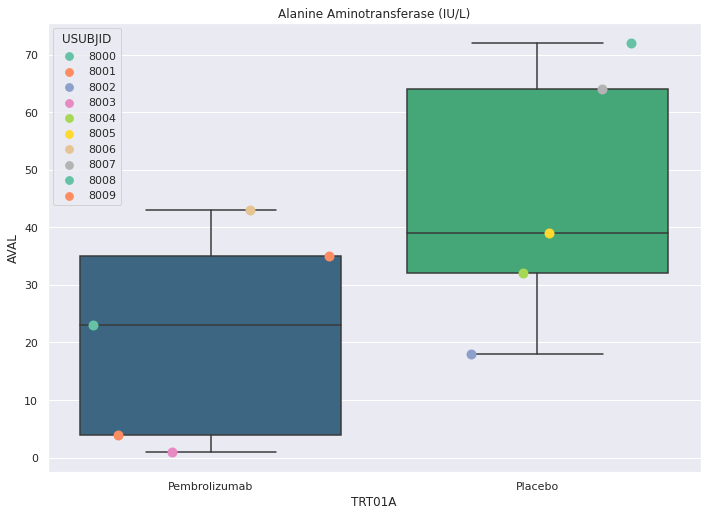

In [52]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
data = query_dynamo("adlb","study1",list_cols = {'PARAMLBL','AVAL'})
data['AVAL'] = data['AVAL'].astype('float')
data = data[data["PARAMLBL"] == "Alanine Aminotransferase (IU/L)"]
sns.boxplot(data=data, 
            x="TRT01A", 
            y="AVAL",
            orient="v",
            palette = 'viridis').set(title=data['PARAMLBL'][0])
sns.stripplot(x='TRT01A', 
              y='AVAL', 
              hue='USUBJID',
              jitter=True,
              dodge=True, 
              marker='o', 
              palette="Set2",
              alpha=1,
              data=data,
              size=10)